Libraries loaded successfully.
Loading Wind Data...
Loading Price Data...
Merging Datasets...
Data Prepared: 8783 hours loaded.

--- BASE CASE RESULTS ---
Total Annual Revenue:    €61,006,897.12
Market Average Price:    €79.58 / MWh
Your Capture Price:      €67.47 / MWh
Cannibalization Loss:   -€12.12 / MWh

Loading Redispatch Data...
Grid Stress Analysis: 44,149 MWh potentially lost to congestion.

Running Real-Case Simulation...
Switching Logic Price: €95.79/MWh
Total Revenue (Hybrid):  €71,967,086.80
Revenue Uplift:          €10,960,189.68

--- FINANCIAL VERDICT ---
LCOH (Production Cost):  €4.87 / kg
Net Present Value (NPV): €7,043,180
Internal Rate of Return: 8.0%


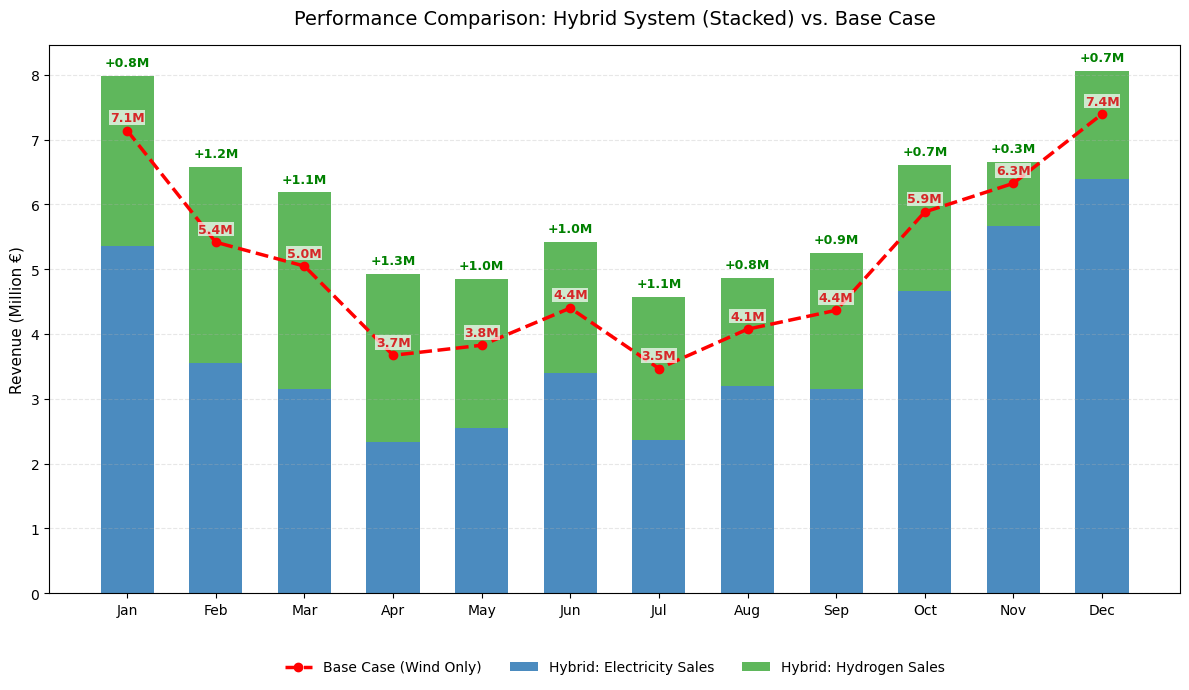

In [1]:
# ==========================================
# STEP 0: IMPORTS & SETUP
# ==========================================
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import numpy_financial as npf  # pip install numpy-financial

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully.")

# ==========================================
# STEP 1: DATA LOADING & CLEANING
# ==========================================

# --- 1.1 Load & Process Wind Data (NetCDF) ---
print("Loading Wind Data...")
ds = xr.open_dataset('E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/Wind_data_ERA5/Reusenkoge_onshore_wind_data.nc')

# Select specific location (index 0) and calculate Wind Speed
ds_at_point = ds.isel(latitude=0, longitude=0)
wind_speed = (ds_at_point['u100']**2 + ds_at_point['v100']**2)**0.5

# Convert to DataFrame and fix Timezone
df_wind = wind_speed.to_dataframe(name='wind_speed_ms')
df_wind.index = df_wind.index.tz_localize('UTC').tz_convert('Europe/Berlin')

# Keep only the column we need
df_wind_clean = df_wind[['wind_speed_ms']]

# --- 1.2 Load & Process Price Data (CSV) ---
print("Loading Price Data...")
df = pd.read_csv('E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/energy-charts_Electricity_production_and_spot_prices_in_Germany_in_2024.csv', 
                 header=0, skiprows=[1])

# Rename and Clean
df_prices_clean = df.rename(columns={
    'Date (GMT+1)': 'datetime',
    'Day Ahead Auction (DE-LU)': 'price_eur_mwh'
})

# Convert datetime and set index
df_prices_clean['datetime'] = pd.to_datetime(df_prices_clean['datetime'])
df_prices_clean = df_prices_clean.set_index('datetime')
df_prices_clean = df_prices_clean[['price_eur_mwh']]
df_prices_clean['price_eur_mwh'] = pd.to_numeric(df_prices_clean['price_eur_mwh'])

# --- 1.3 Merge DataFrames ---
print("Merging Datasets...")
df_master = df_wind_clean.join(df_prices_clean)
df_master = df_master.dropna()  # Remove empty rows

# --- 1.4 Calculate Power Output (Wind Curve) ---
TOTAL_FARM_CAPACITY_MW = 210 

def calculate_power(wind_speed):
    if wind_speed < 3:  return 0.0
    elif wind_speed < 13: return (wind_speed - 3) / (13 - 3) * TOTAL_FARM_CAPACITY_MW
    elif wind_speed < 25: return TOTAL_FARM_CAPACITY_MW
    else: return 0.0

df_master['power_mw'] = df_master['wind_speed_ms'].apply(calculate_power)

print(f"Data Prepared: {len(df_master)} hours loaded.")

# ==========================================
# STEP 2: BASE CASE ANALYSIS (Wind Only)
# ==========================================

# 1. Calculate Base Revenue
df_master['base_revenue_eur'] = df_master['power_mw'] * df_master['price_eur_mwh']
total_annual_revenue_base = df_master['base_revenue_eur'].sum()

# 2. Capture Price Analysis (Cannibalization)
total_generation_mwh = df_master['power_mw'].sum()
capture_price = total_annual_revenue_base / total_generation_mwh
market_average = df_master['price_eur_mwh'].mean()
cannibalization_loss = market_average - capture_price

print("\n--- BASE CASE RESULTS ---")
print(f"Total Annual Revenue:    €{total_annual_revenue_base:,.2f}")
print(f"Market Average Price:    €{market_average:.2f} / MWh")
print(f"Your Capture Price:      €{capture_price:.2f} / MWh")
print(f"Cannibalization Loss:   -€{cannibalization_loss:.2f} / MWh")

# ==========================================
# STEP 3: GRID CONGESTION (REDISPATCH)
# ==========================================
# Note: This step calculates "Lost Energy" due to grid stress but 
# currently doesn't stop the arbitrage logic below (unless you modify the logic).

print("\nLoading Redispatch Data...")
folder_path = 'E:/Arbitrage_Model_project/wind-h2-arbitrage/DATA/Redispatched'
all_files = glob.glob(os.path.join(folder_path, "*.csv"))

if all_files:
    df_list = []
    for filename in all_files:
        temp_df = pd.read_csv(filename, header=0, skiprows=[1])
        df_list.append(temp_df)
    
    df_redispatch = pd.concat(df_list, axis=0, ignore_index=True)
    
    # Clean Redispatch Data
    target_col = 'DE (TenneT) Load decrease (current-induced)'
    # Fallback if column name differs
    if target_col not in df_redispatch.columns:
        target_col = 'DE (TenneT) Load decrease (current-induced) [MW]'

    df_redispatch = df_redispatch.rename(columns={'Date (GMT+1)': 'datetime', target_col: 'region_curtailment_mw'})
    df_redispatch['datetime'] = pd.to_datetime(df_redispatch['datetime'], utc=True, errors='coerce')
    df_redispatch = df_redispatch.dropna(subset=['datetime']).set_index('datetime').sort_index()
    
    # Resample to Hourly
    df_redispatch_hourly = df_redispatch[['region_curtailment_mw']].resample('H').mean().fillna(0)
    
    # Calculate Grid Stress
    max_curtailment = df_redispatch_hourly['region_curtailment_mw'].min()
    if max_curtailment == 0: max_curtailment = -1
    
    df_redispatch_hourly['grid_stress'] = df_redispatch_hourly['region_curtailment_mw'] / max_curtailment
    
    # Join to Master
    df_master = df_master.join(df_redispatch_hourly['grid_stress'], how='left').fillna(0)
    
    # Calculate theoretical lost energy
    def calculate_physical_curtailment(row):
        wind_mw = row['power_mw']
        stress = row['grid_stress']
        if stress > 0:
            allowed_pct = 1.0 - stress
            curtailment_limit = TOTAL_FARM_CAPACITY_MW * allowed_pct
            actual = min(wind_mw, curtailment_limit)
            return pd.Series([actual, wind_mw - actual])
        else:
            return pd.Series([wind_mw, 0])

    df_master[['grid_limited_power', 'lost_mwh']] = df_master.apply(calculate_physical_curtailment, axis=1)
    print(f"Grid Stress Analysis: {df_master['lost_mwh'].sum():,.0f} MWh potentially lost to congestion.")

else:
    print("No redispatch files found. Skipping Grid Stress analysis.")

# ==========================================
# STEP 4: HYDROGEN ARBITRAGE SIMULATION
# ==========================================
print("\nRunning Real-Case Simulation...")

# Parameters (Siemens Silyzer 300)
ELECTROLYZER_MW = 50
H2_EFFICIENCY_KWH_KG = 52.2       
H2_PRICE_EUR_KG = 5.00            
MIN_LOAD_PCT = 0.10               

# 1. Calculate Breakeven
h2_breakeven_price = (1000 / H2_EFFICIENCY_KWH_KG) * H2_PRICE_EUR_KG
print(f"Switching Logic Price: €{h2_breakeven_price:.2f}/MWh")

# 2. Define Logic Function
def calculate_real_hybrid_revenue(row):
    wind_mw = row['power_mw']
    price = row['price_eur_mwh']
    
    min_power_mw = ELECTROLYZER_MW * MIN_LOAD_PCT # 5 MW
    
    # LOGIC: If Price is high OR Wind is too low -> Sell to Grid
    if (price >= h2_breakeven_price) or (wind_mw < min_power_mw):
        return pd.Series([wind_mw * price, 0, 0])
        
    # LOGIC: Make H2
    else:
        power_to_h2 = min(wind_mw, ELECTROLYZER_MW)
        power_to_grid = wind_mw - power_to_h2
        
        h2_produced_kg = (power_to_h2 * 1000) / H2_EFFICIENCY_KWH_KG
        
        h2_rev = h2_produced_kg * H2_PRICE_EUR_KG
        grid_rev = power_to_grid * price 
        
        return pd.Series([grid_rev, h2_rev, h2_produced_kg])

# 3. Apply Logic
df_master[['real_grid_rev', 'real_h2_rev', 'real_h2_kg']] = df_master.apply(calculate_real_hybrid_revenue, axis=1)

# 4. Results
df_master['total_real_revenue'] = df_master['real_grid_rev'] + df_master['real_h2_rev']
total_annual_revenue_real = df_master['total_real_revenue'].sum()
revenue_uplift_real = total_annual_revenue_real - total_annual_revenue_base

print(f"Total Revenue (Hybrid):  €{total_annual_revenue_real:,.2f}")
print(f"Revenue Uplift:          €{revenue_uplift_real:,.2f}")

# ==========================================
# STEP 5: FINANCIAL EVALUATION (LCOH & DCF)
# ==========================================

# Assumptions
CAPEX_PER_KW = 1800 
total_capex_eur = (ELECTROLYZER_MW * 1000) * CAPEX_PER_KW
annual_opex = total_capex_eur * 0.02
WACC = 0.07
LIFETIME = 20

# 1. LCOH Calculation
crf = (WACC * (1 + WACC)**LIFETIME) / ((1 + WACC)**LIFETIME - 1)
annualized_capex = total_capex_eur * crf
grid_revenue_lost = df_master['base_revenue_eur'].sum() - df_master['real_grid_rev'].sum()
total_annual_cost = annualized_capex + annual_opex + grid_revenue_lost
total_h2 = df_master['real_h2_kg'].sum()
lcoh_eur_kg = total_annual_cost / total_h2

# 2. DCF / NPV Calculation
cash_flows = [-total_capex_eur] # Year 0
annual_profit = revenue_uplift_real - annual_opex # Years 1-20
for year in range(1, LIFETIME + 1):
    cash_flows.append(annual_profit)

npv = npf.npv(WACC, cash_flows)
irr = npf.irr(cash_flows)

print("\n--- FINANCIAL VERDICT ---")
print(f"LCOH (Production Cost):  €{lcoh_eur_kg:.2f} / kg")
print(f"Net Present Value (NPV): €{npv:,.0f}")
print(f"Internal Rate of Return: {irr:.1%}")

# ==========================================
# STEP 6: VISUALIZATION (Side-by-Side)
# ==========================================

# Aggregation
# --- 1. PREPARE DATA ---
# Ensure the index is datetime for resampling
if not isinstance(df_master.index, pd.DatetimeIndex):
    df_master.index = pd.to_datetime(df_master.index)

# Resample to Monthly sums
monthly_stats = df_master.resample('M').sum()
months = monthly_stats.index.strftime('%b')

# Convert to Millions for clean plotting
revenue_grid = monthly_stats['real_grid_rev'] / 1_000_000
revenue_h2 = monthly_stats['real_h2_rev'] / 1_000_000
revenue_base = monthly_stats['base_revenue_eur'] / 1_000_000

# --- 2. SETUP PLOT ---
plt.figure(figsize=(12, 7)) # Matches the aspect ratio of your image
x = np.arange(len(months)) 
width = 0.6 # Adjust bar width

# --- 3. PLOT STACKED BARS ---
# Blue Bar (Grid Electricity)
p1 = plt.bar(months, revenue_grid, width, color='#377eb8', label='Hybrid: Electricity Sales', alpha=0.9)
# Green Bar (Hydrogen) - Stacked on top
p2 = plt.bar(months, revenue_h2, width, bottom=revenue_grid, color='#4daf4a', label='Hybrid: Hydrogen Sales', alpha=0.9)

# --- 4. PLOT BASELINE (RED LINE) ---
plt.plot(months, revenue_base, color='red', marker='o', linewidth=2.5, linestyle='--', label='Base Case (Wind Only)')

# --- 5. ADD LABELS (THE "MAGIC" PART) ---

# A. Red Labels (Base Case Values)
for i, value in enumerate(revenue_base):
    plt.text(i, value + 0.1,       # Position slightly above the red dot
             f'{value:.1f}M',      # Text
             ha='center', va='bottom', 
             color='#d62728',      # Red text
             fontsize=9, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor='none', alpha=0.7, pad=0.5))

# B. Green Labels (The "Uplift" Difference)
total_hybrid = revenue_grid + revenue_h2
for i, (base, hybrid) in enumerate(zip(revenue_base, total_hybrid)):
    diff = hybrid - base
    # Only label if the gain is visible (>0.1M)
    if diff > 0.1:
        plt.text(i, hybrid + 0.1,  # Position above the green bar
                 f'+{diff:.1f}M',  # Text with plus sign
                 ha='center', va='bottom',
                 color='green',    # Green text
                 fontsize=9, fontweight='bold')

# --- 6. STYLING ---
plt.ylabel('Revenue (Million €)', fontsize=11)
plt.title('Performance Comparison: Hybrid System (Stacked) vs. Base Case', fontsize=14, pad=15)
plt.grid(axis='y', linestyle='--', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, frameon=False)

# --- 7. SAVE OUTPUT ---
plt.tight_layout()
plt.savefig("Final_Hybrid_vs_Base_Plot.png", dpi=300) # Saves high-res image
plt.show()